# Spectrograms - CNN Test

In [13]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam

import sqlalchemy
from sqlalchemy import create_engine, inspect

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from pprint import pprint

import os
import sys
import time
from datetime import datetime
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

%run functions.ipynb

In [2]:
# Time the run
start_time = time.time()

## Import datasets

In [3]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['alexaval',
 'alexbval',
 'alexgval',
 'alexrval',
 'aval',
 'bval',
 'chroma1',
 'chroma10',
 'chroma11',
 'chroma12',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chromastd',
 'delta',
 'deltachroma1',
 'deltachroma10',
 'deltachroma11',
 'deltachroma12',
 'deltachroma2',
 'deltachroma3',
 'deltachroma4',
 'deltachroma5',
 'deltachroma6',
 'deltachroma7',
 'deltachroma8',
 'deltachroma9',
 'deltachromastd',
 'deltaenergy',
 'deltaenergyentropy',
 'deltamfcc1',
 'deltamfcc10',
 'deltamfcc11',
 'deltamfcc12',
 'deltamfcc13',
 'deltamfcc2',
 'deltamfcc3',
 'deltamfcc4',
 'deltamfcc5',
 'deltamfcc6',
 'deltamfcc7',
 'deltamfcc8',
 'deltamfcc9',
 'deltaspectralcentroid',
 'deltaspectralentropy',
 'deltaspectralflux',
 'deltaspectralrolloff',
 'deltaspectralspread',
 'deltazcr',
 'demographic',
 'diagnosis',
 'energy',
 'energyentropy',
 'gval',
 'habits',
 'mfcc1',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc2',
 'mfcc3',
 'mfcc4

In [4]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in table_names:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

## Preprocessing

### Define the target variable

In [5]:
# Sort the diagnosis dataframe
dataframes['diagnosis_df'] = dataframes['diagnosis_df'].sort_values(by='id').reset_index(drop=True)

# Isolate the diagnosis column
y = dataframes['diagnosis_df']['diagnosis'].copy()


# Encode the target variable, ignore subtype
y = y.apply(encode_binary)
y

0      1
1      0
2      1
3      1
4      1
      ..
199    0
200    1
201    0
202    0
203    1
Name: diagnosis, Length: 204, dtype: int64

In [6]:
# Check the aval_df
dataframes['pylabaval_df'].describe()

,voice156,voice142,voice195,voice181,voice022,voice036,voice208,voice037,voice023,voice180,...,voice166,voice199,voice012,voice204,voice205,voice013,voice007,voice198,voice167,voice173
count,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,...,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0,65536.0
mean,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
25%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
50%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
75%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
max,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


__NOTE__: The A-channel is all the same, might not be adding value.

### Reshape the feature variables

In [7]:
# Input shape
# width_px = 225
# height_px = 166

# alex
# width_px = 227
# height_px = 227

width_px = 256
height_px = 256
num_channels = 3 # since RGB

# Define inputs
input_shape = (height_px, width_px, num_channels)
input_reshape = (height_px, width_px)

,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,248,248,248,248,248,248,248,248,248,248,...,248,248,248,255,248,248,248,248,248,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,253,253,253,253,253,253,252,253,253,253,...,253,253,253,253,253,253,253,253,253,253
65532,253,253,253,253,253,253,252,253,253,253,...,253,253,253,253,253,253,253,253,253,253
65533,253,253,253,253,253,253,252,253,253,253,...,253,253,253,253,253,253,253,253,253,253
65534,253,253,253,253,253,253,252,253,253,253,...,253,253,253,253,253,253,253,253,253,253


,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,251,251,252,251,251,251,251,251,251,251,...,251,252,252,255,251,252,252,251,251,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231
65532,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231
65533,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231
65534,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231


,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,251,251,251,251,251,251,251,251,251,251,...,251,251,251,255,251,251,251,251,251,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,36,36,36,36,36,36,35,36,36,36,...,36,36,36,36,36,36,36,36,36,36
65532,36,36,36,36,36,36,35,36,36,36,...,36,36,36,36,36,36,36,36,36,36
65533,36,36,36,36,36,36,35,36,36,36,...,36,36,36,36,36,36,36,36,36,36
65534,36,36,36,36,36,36,35,36,36,36,...,36,36,36,36,36,36,36,36,36,36


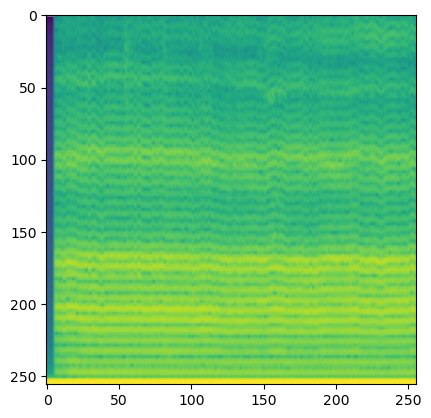

In [8]:
# Dataframe order
# rgba_order = ['rval_df', 'gval_df', 'bval_df', 'aval_df']
# rgb_order = ['rval_df', 'gval_df', 'bval_df']
# rgb_order = ['alexrval_df', 'alexgval_df', 'alexbval_df']
rgb_order = ['pylabrval_df', 'pylabgval_df', 'pylabbval_df']

# Initialise list to hold the dataframes
rgba_df_list = []

# Loop through all the dataframes
for df in rgb_order:
    
    # Sort the columns
    dataframes[df] = dataframes[df].sort_index(axis=1)
    display(dataframes[df])
    
    # Define the df columns
    df_cols = dataframes[df].columns

    # Reshape to its original dimensions
    data = np.array(
        [dataframes[df][col].values.reshape(input_reshape) for col in df_cols]
    )

    # Append to the list
    rgba_df_list.append(data)

# Define the feature variables
X = np.stack(rgba_df_list, axis=-1)

# Display the first for confirmation
plt.imshow(X[0])
plt.show()

### Split and Scale

In [29]:
# Split the preprocessed data to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [41]:
type(X_train)

numpy.ndarray

In [37]:
X_train.shape

(153, 256, 256, 3)

In [30]:
# Reshape the data
X_train_reshaped = X_train.reshape((
    X_train.shape[0], # total number of samples
    height_px * width_px * num_channels # total number flattened
))

X_test_reshaped = X_test.reshape((
    X_test.shape[0],
    height_px * width_px * num_channels
))

In [35]:
X_train_reshaped.shape

(153, 196608)

In [40]:
X_train_reshaped[0]

array([255, 255, 255, ..., 253, 231,  36])

In [11]:
# Normalize training data to be between 0 and 1
X_scaler = MinMaxScaler()

# Scale the data
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.fit_transform(X_test_reshaped)

# Reshape the data back to the original
X_train_scaled = X_train_scaled.reshape((
    X_train_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

X_test_scaled = X_test_scaled.reshape((
    X_test_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

In [36]:
X_train_scaled.shape

(153, 256, 256, 3)

## Initial Test Model

__GUIDELINES__

- The number of filters for convolutional layers should:
    - Be a value to the power of 2
    - Increase for each following layer (i.e. `32`, `64`, `128`)
- The number of neurons for the fully connected layers should:
    - Be a value to the power of 2
    - Decrease for each following layer (i.e. `64`, `32`)
- Kernel size must be an odd integer

In [15]:
cnn = Sequential()
cnn.add(Input(shape=(height_px, width_px, num_channels)))
cnn.add(Conv2D(32, 3, strides=2, padding='same', activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, 3, padding='same', activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, 3, padding='same', activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='softmax'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

In [16]:
# Compile the model
cnn.compile(
    optimizer = 'adam',
    # optimizer = Adam(lr=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [17]:
# Train the model
cnn.fit(
    X_train_scaled,
    y_train,
    epochs = 15,
    shuffle = True, # reduce risk of overfitting
    verbose = 1
)

Epoch 1/15
5/5 [==============================] - 1s 172ms/step - loss: 1.4182 - accuracy: 0.7190
Epoch 2/15
5/5 [==============================] - 1s 162ms/step - loss: 0.7732 - accuracy: 0.7190
Epoch 3/15
5/5 [==============================] - 1s 162ms/step - loss: 0.4210 - accuracy: 0.7190
Epoch 4/15
5/5 [==============================] - 1s 164ms/step - loss: 0.2979 - accuracy: 0.7190
Epoch 5/15
5/5 [==============================] - 1s 165ms/step - loss: 0.3637 - accuracy: 0.7190
Epoch 6/15
5/5 [==============================] - 1s 168ms/step - loss: 0.2759 - accuracy: 0.7190
Epoch 7/15
5/5 [==============================] - 1s 162ms/step - loss: 0.2021 - accuracy: 0.7190
Epoch 8/15
5/5 [==============================] - 1s 160ms/step - loss: 0.1429 - accuracy: 0.7190
Epoch 9/15
5/5 [==============================] - 1s 161ms/step - loss: 0.1229 - accuracy: 0.7190
Epoch 10/15
5/5 [==============================] - 1s 166ms/step - loss: 0.1169 - accuracy: 0.7190
Epoch 11/15
5/5 [==

In [18]:
# Evaluate the model using the test data
model_loss, model_accuracy = cnn.evaluate(
    X_test_scaled,
    y_test,
    verbose = 2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 1.1636 - accuracy: 0.7255 - 256ms/epoch - 128ms/step
Loss: 1.1635761260986328, Accuracy: 0.7254902124404907


## Save Results to Performance Tracker

In [19]:
# Create dictionary to save the results
results_dict = dict()

current_time = datetime.now()
results_dict['timestamp'] = current_time
results_dict['runtime'] = time.time() - start_time
results_dict['model_loss'] = model_loss
results_dict['model_accuracy'] = model_accuracy

In [20]:
# Change message
change_message = input("Changes from previous iteration: ")

# Append to results_dict
results_dict['change_message'] = change_message

Changes from previous iteration:  new spectrogram images, returned to 'adam'


In [21]:
# Display the dictionary
results_dict

{'timestamp': datetime.datetime(2024, 1, 6, 19, 55, 7, 546224),
 'runtime': 126.95105409622192,
 'model_loss': 1.1635761260986328,
 'model_accuracy': 0.7254902124404907,
 'change_message': "new spectrogram images, returned to 'adam'"}

In [22]:
# Model summary folder path
summary_path = '../resources/tracker/cnn_summary/'
num_files = len(os.listdir(summary_path))

# Export summary to text file
with open(f'{summary_path}cnn_summary_{num_files}.txt', 'w') as f:
    with redirect_stdout(f):
        cnn.summary()
        pprint(results_dict)

In [23]:
# Convert the dictionary to a dataframe
results_df = pd.DataFrame(results_dict, index=[0])
results_df.head()

,timestamp,runtime,model_loss,model_accuracy,change_message
0,2024-01-06 19:55:07.546224,126.951054,1.163576,0.72549,"new spectrogram images, returned to 'adam'"


In [24]:
# Performance tracker
tracker_path = "../resources/tracker/cnn_performance_tracker.csv"

# Model percentage
model_pct = round(model_accuracy, 3)

# Check if the CSV exists
if os.path.exists(tracker_path):
    
    # Read the existing CSV
    tracker_df = pd.read_csv(tracker_path)
    
    # Append the new row of data
    updated_df = pd.concat([tracker_df, results_df], ignore_index=True)
    
    # Update the CSV file
    updated_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_{len(tracker_df)}_{model_pct}.h5', save_format='h5')

else:    
    # Export to CSV
    results_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_0_{model_pct}.h5', save_format='h5')

/Users/alyssahondrade/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save Model Results to CSV

In [25]:
# Check the prediction's output probabilities
predicted_prob = cnn.predict(X_test_scaled)
clean_prob = np.round(predicted_prob, 2)

# Round to the nearest integer and flatten
clean_predicted = np.round(predicted_prob).astype(int).flatten()

# Convert to a dataframe for readability
output_prob = pd.DataFrame({
    'Actual': y_test,
    'Predicted': clean_predicted,
    'Probability': clean_prob.flatten()
})

output_prob

2/2 [==============================] - 0s 36ms/step


,Actual,Predicted,Probability
178,0,1,1.0
75,1,1,1.0
202,0,1,1.0
164,1,1,1.0
11,1,1,1.0
17,1,1,1.0
185,1,1,1.0
200,1,1,1.0
90,0,1,1.0
72,1,1,1.0


In [26]:
output_prob.loc[output_prob['Actual'] != output_prob['Predicted']]

,Actual,Predicted,Probability
178,0,1,1.0
202,0,1,1.0
90,0,1,1.0
99,0,1,1.0
95,0,1,1.0
102,0,1,1.0
176,0,1,1.0
97,0,1,1.0
80,0,1,1.0
85,0,1,1.0
